## Imports

In [1]:
# Python imports
import os
import sys
import json
from pathlib import Path
import gc
import inspect
from copy import deepcopy
from copy import copy
from datetime import datetime

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm.notebook import tqdm

In [2]:
# Transformer imports
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
import torch

In [3]:
# Local imports
sys.path.insert(0, '..')
from visualization.visualization_utils import *

sys.path.insert(0, '../DSL')
from dsl import *
from constants import *
from solver_class import Solver
import solvers
import verifiers
import verifiers_reformatted

## Hyperparameters

In [4]:
num_train_epochs = 20
num_re_arc_examples_per_task_per_epoch = 20

## Load data

In [5]:
data_path = Path('../data')
train_path = data_path / 'arc-agi_training_challenges.json'
train_sols_path = data_path / 'arc-agi_training_solutions.json'
eval_path = data_path / 'arc-agi_evaluation_challenges.json'
eval_sols_path = data_path / 'arc-agi_evaluation_solutions.json'
re_arc_path = data_path / 're-arc_tasks'

In [6]:
with open(train_path, 'r') as f:
    train_tasks = json.load(f)
with open(train_sols_path, 'r') as f:
    train_sols = json.load(f)

train_task_labels = sorted(train_tasks.keys())

#with open(eval_path, 'r') as f:
#    eval_tasks = json.load(f)
#with open(eval_sols_path, 'r') as f:
#    eval_sols = json.load(f)

#eval_task_labels = sorted(eval_tasks.keys())

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}")

Using cuda


## Load model and tokenizer

In [8]:
codegen_tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono",
                                                 #padding_side='left', # For padding batches of input in decoder-only context
                                                 clean_up_tokenization_spaces = True,
                                                 )
codegen = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono")
codegen = codegen.to(DEVICE)

In [9]:
EOS_TOKEN = codegen_tokenizer.eos_token
BOS_TOKEN = codegen_tokenizer.bos_token
codegen_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
#codegen_tokenizer.pad_token = codegen_tokenizer.eos_token

1

## Create training data

In [10]:
# Load Hodel's solvers and verifiers.
# Verifiers are reformatted to look the same as the solvers.
solver_programs = {label: Solver(inspect.getsource(getattr(solvers, f"solve_{label}"))) for label in train_task_labels}
verifier_programs = {label: Solver(inspect.getsource(getattr(verifiers_reformatted, f"solve_{label}"))) for label in train_task_labels}

In [11]:
# TODO: Refactor to utilities file

def grid_to_string(grid):
    """
    Simply converts grid to string and removes whitespace.
    A 30-by-30 grid will use ~1800 tokens.
    """
    return str(grid).replace(" ", "")

def grid_to_string_compact(grid):
    """
    Rows as strings of characters separated by linebreaks.
    Uses approximately 4-times fewer tokens than grid_to_string.
    """
    return "\n".join(["".join([str(entry) for entry in row]) for row in grid])

In [12]:
def get_n_random_re_arc_pairs(label: str, n: int) -> list[dict]:
    with open(re_arc_path / f"{label}.json", "r") as f:
        re_arc_examples = json.load(f)
    return random.sample(re_arc_examples, n)

In [13]:
def create_training_example(solver: Solver, in_grid, out_grid, compact = True) -> str:
    """
    No more than ~1600 tokens needed in worst case to encode a training example,
    assuming compact = True
    """
    in_grid_str = grid_to_string_compact(in_grid) if compact else grid_to_string(in_grid)
    out_grid_str = grid_to_string_compact(out_grid) if compact else grid_to_string(out_grid)

    docstring = f"""
    Example input:
    {in_grid_str}
    Example output:
    {out_grid_str}
    """
    solver.update_docstring(docstring)
    
    solver_text = str(solver).strip()
    return solver_text + EOS_TOKEN

In [15]:
# Show an example
l = random.choice(train_task_labels)
print(l)
print("")
in_grid = train_tasks[l]['train'][0]['input']
out_grid = train_tasks[l]['train'][0]['output']
solver = solver_programs[l]
print(create_training_example(solver, in_grid, out_grid))

5c0a986e

def solve_5c0a986e(I):
    """
    Example input:
    0000000000
    0000000000
    0011000000
    0011000000
    0000000000
    0000000000
    0000220000
    0000220000
    0000000000
    0000000000
    Example output:
    1000000000
    0100000000
    0011000000
    0011000000
    0000000000
    0000000000
    0000220000
    0000220000
    0000002000
    0000000200
    """
    x1 = ofcolor(I, TWO)
    x2 = ofcolor(I, ONE)
    x3 = lrcorner(x1)
    x4 = ulcorner(x2)
    x5 = shoot(x3, UNITY)
    x6 = shoot(x4, NEG_UNITY)
    x7 = fill(I, TWO, x5)
    O = fill(x7, ONE, x6)
    return O<|endoftext|>


In [16]:
# Check worst case for number of tokens needed to encode an example
max_tokens_needed = 0
for label in tqdm(train_task_labels):
    solver = solver_programs[label]
    verifier = verifier_programs[label]
    N = len(train_tasks[label]['train'])
    M = len(train_tasks[label]['test'])
    for i in range(N):
        in_grid = train_tasks[label]['train'][i]['input']
        out_grid = train_tasks[label]['train'][i]['output']
        solver_ex = create_training_example(solver, in_grid, out_grid)
        verifier_ex = create_training_example(verifier, in_grid, out_grid)
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(solver_ex)))
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(verifier_ex)))
    for i in range(M):
        in_grid = train_tasks[label]['test'][i]['input']
        out_grid = train_sols[label][i]
        solver_ex = create_training_example(solver, in_grid, out_grid)
        verifier_ex = create_training_example(verifier, in_grid, out_grid)
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(solver_ex)))
        max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(verifier_ex)))
    with open(re_arc_path / f"{label}.json") as f:
        re_arc_pairs = json.load(f)
        for pair in re_arc_pairs:
            in_grid = pair['input']
            out_grid = pair['output']
            solver_ex = create_training_example(solver, in_grid, out_grid)
            verifier_ex = create_training_example(verifier, in_grid, out_grid)
            max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(solver_ex)))
            max_tokens_needed = max(max_tokens_needed, len(codegen_tokenizer.tokenize(verifier_ex)))

  0%|          | 0/400 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2062 > 2048). Running this sequence through the model will result in indexing errors


In [17]:
print(f"Maximum number of tokens possibly needed for training examples: {max_tokens_needed}")

Maximum number of tokens possibly needed for training examples: 2792


In [18]:
# TODO: Find a way to sample different re-arc grid pairs every epoch

training_examples = []

for label in train_task_labels:
    N = len(train_tasks[label]['train'])
    M = len(train_tasks[label]['test'])
    
    solver = solver_programs[label]
    verifier = verifier_programs[label]

    # Create solver examples from ordinary arc tasks
    for i in range(N):
        in_grid = train_tasks[label]['train'][i]['input']
        out_grid = train_tasks[label]['train'][i]['output']
        solver_ex = create_training_example(solver, in_grid, out_grid)
        solver.randomize_name()
        training_examples.append(solver_ex)
    for i in range(M):
        in_grid = train_tasks[label]['test'][i]['input']
        out_grid = train_sols[label][i]
        solver.randomize_name()
        solver_ex = create_training_example(solver, in_grid, out_grid)
        training_examples.append(solver_ex)

    # Create verifier examples from re-arc tasks
    re_arc_pairs = get_n_random_re_arc_pairs(label, n = num_re_arc_examples_per_task_per_epoch)
    for pair in re_arc_pairs:
        in_grid = pair['input']
        out_grid = pair['output'] 
        verifier.randomize_name()
        verifier_ex = create_training_example(verifier, in_grid, out_grid)
        training_examples.append(verifier_ex)

In [19]:
print(f"We have {len(training_examples)} training examples, an average of {len(training_examples) / 400} per task.")

We have 9718 training examples, an average of 24.295 per task.


In [20]:
token_counts = [len(codegen_tokenizer.tokenize(example)) for example in training_examples]

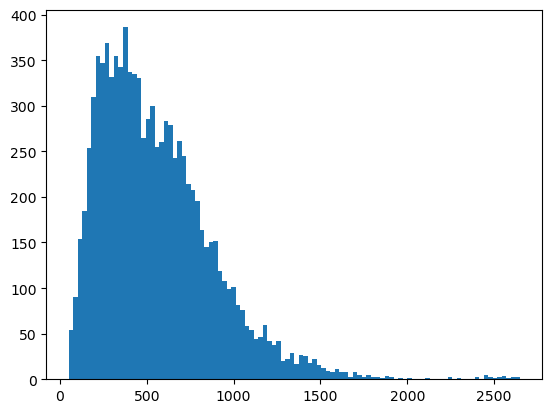

Maximum number of tokens actually needed for training examples: 2648
A total of 25 examples exceed 2048 tokens
A total of 103 examples exceed 1536 tokens


In [21]:
plt.hist(token_counts, bins = 100)
plt.show()
print(f"Maximum number of tokens actually needed for training examples: {max(token_counts)}")
print(f"A total of {sum([count > 2048 for count in token_counts])} examples exceed 2048 tokens")
print(f"A total of {sum([count > 1536 for count in token_counts])} examples exceed 1536 tokens")

In [22]:
dataset = Dataset.from_dict({'text': training_examples})

## Train and save

In [23]:
trainer = SFTTrainer(
    model = codegen,
    tokenizer = codegen_tokenizer,
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        dataset_text_field = "text",
        max_seq_length = 1536, # 2048 is took big, OOM. Also got OOM with 1536 unfortunately.
        num_train_epochs = num_train_epochs,
        learning_rate = 2e-4,
        fp16 = True,
        bf16 = False,
        logging_steps = 400,
        save_steps = 1000,
        optim = "adamw_torch",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/9718 [00:00<?, ? examples/s]

In [24]:
trainer.train()

Step,Training Loss
400,0.806700
800,0.598200
1200,0.548400
1600,0.486400
2000,0.475600
2400,0.469100
2800,0.415300
3200,0.411600
3600,0.420400
4000,0.367800


TrainOutput(global_step=24280, training_loss=0.16982424422190256, metrics={'train_runtime': 13838.4369, 'train_samples_per_second': 14.045, 'train_steps_per_second': 1.755, 'total_flos': 1.9634600413888512e+17, 'train_loss': 0.16982424422190256, 'epoch': 19.987651780201688})